In [1]:
from pipe import *

In [2]:
random_seed=1234
np.random.seed(random_seed)

data_size=1000

data_x=np.random.uniform(0,10,size=data_size)
ture_theta=np.random.uniform(0,5,size=2)
sigma2=np.random.uniform(0,5,size=1)

print("My true theta:", ture_theta)
print("My sigma2 vlaue:", sigma2)

data_y=make_nosie_data(data_x,ture_theta,sigma2,random_seed=random_seed)

My true theta: [2.00553204 4.65307201]
My sigma2 vlaue: [2.57668073]


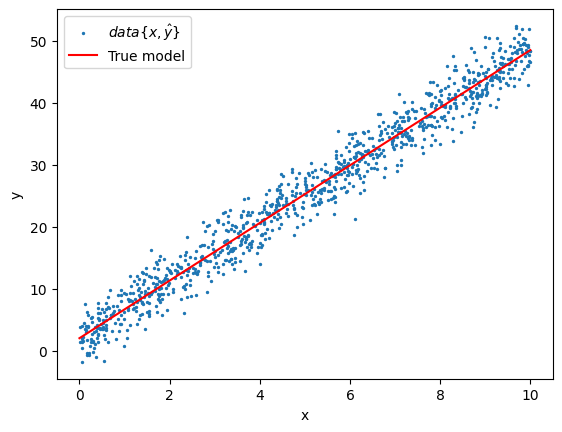

In [3]:
linera_x=np.linspace(0,10,100)

linear_y=linear_model(linera_x,ture_theta)
plt.scatter(data_x,data_y,s=2,label=r'$data \{ x, \hat{y} \} $')
plt.plot(linera_x,linear_y,c='r',label='True model')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

In [4]:
mycode=my_MCMC(data_x,data_y)

In [5]:
from scipy.optimize import minimize

result = minimize(lambda theta: -1 * mycode.log_probability(theta), [0,0])
print(result.x)


[2.0416215  4.65391762]


/Users/gimhyeon/my_code/MCMC/pipe.py:48: RuntimeWarning: divide by zero encountered in log
  return np.log(total_prior)
/Users/gimhyeon/miniconda3/envs/camb/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
/Users/gimhyeon/my_code/MCMC/pipe.py:48: RuntimeWarning: divide by zero encountered in log
  return np.log(total_prior)


In [6]:
from scipy.stats import chi2

delta_1sigma=-chi2.ppf(0.683, df=2)/2
print(delta_1sigma*2)


-2.297707010209713


In [7]:
nn=300
parameter_size=0.5

theta0=np.linspace(result.x[0]-parameter_size/2,result.x[0]+parameter_size/2,nn)
theta1=np.linspace(result.x[1]-parameter_size/2,result.x[1]+parameter_size/2,nn)

mytheta=np.array([[ii,jj] for jj in theta1 for ii in theta0])

log_L_arr=np.zeros(nn**2)
log_p_arr=np.zeros(nn**2)
log_pi_arr=np.zeros(nn**2)

for ii, input_theta in enumerate(mytheta):
    log_L_arr[ii]=mycode.log_likelihood(input_theta)
    log_pi_arr[ii]=mycode.log_prior(input_theta)
    log_p_arr[ii]=mycode.log_probability(input_theta)


log_L_arr=np.reshape(log_L_arr,(nn,nn))
log_pi_arr=np.reshape(log_pi_arr,(nn,nn))
log_p_arr=np.reshape(log_p_arr,(nn,nn))

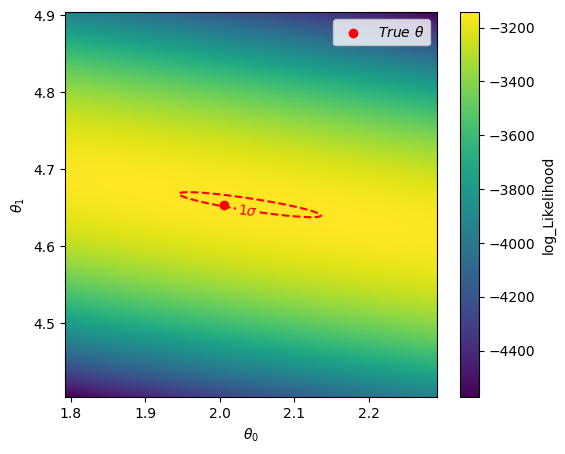

In [8]:
Theta0, Theta1 = np.meshgrid(theta0, theta1)

logL_max = np.max(log_L_arr)

levels = [logL_max + delta_1sigma]


plt.figure(figsize=(6, 5))
im = plt.imshow(log_L_arr, origin='lower', extent=[theta0.min(), theta0.max(), theta1.min(), theta1.max()],
                cmap='viridis', aspect='auto')
cs = plt.contour(Theta0, Theta1, log_L_arr, levels=levels, colors='red')
plt.clabel(cs, fmt={levels[0]: r'$1\sigma$'})
plt.scatter(ture_theta[0],ture_theta[1],c='r',label=r'$True \ \theta$')

plt.colorbar(im, label='log_Likelihood')
plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
plt.legend()
plt.show()



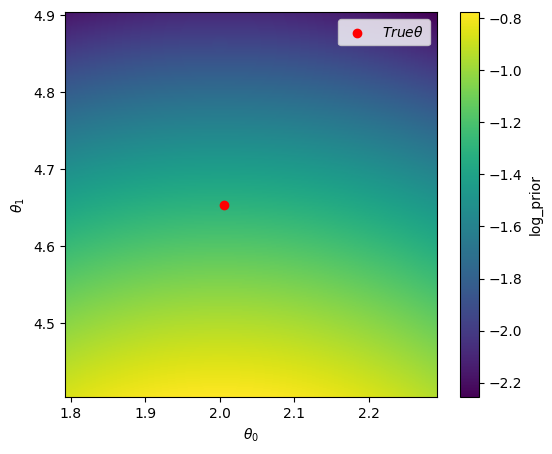

In [9]:
plt.figure(figsize=(6, 5))
im = plt.imshow(log_pi_arr, origin='lower', extent=[theta0.min(), theta0.max(), theta1.min(), theta1.max()],
                cmap='viridis', aspect='auto')
plt.scatter(ture_theta[0],ture_theta[1],c='r',label=r'$True \theta$')
plt.colorbar(im, label='log_prior')
plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
plt.legend()
plt.show()


Best estimates:  [2.04245762 4.64973702]


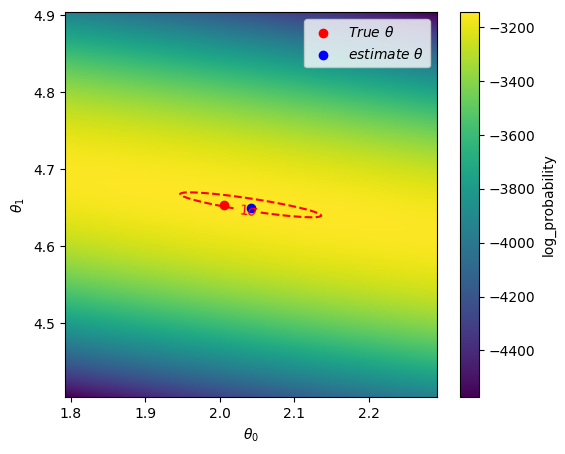

In [10]:

log_p_max = np.max(log_p_arr)

levels = [log_p_max + delta_1sigma]

estimate=np.array([theta0[np.where(log_p_arr==log_p_max)[0][0]],theta1[np.where(log_p_arr==log_p_max)[1][0]]])


print("Best estimates: ",estimate)



plt.figure(figsize=(6, 5))
im = plt.imshow(log_p_arr, origin='lower', extent=[theta0.min(), theta0.max(), theta1.min(), theta1.max()],
                cmap='viridis', aspect='auto')
cs = plt.contour(Theta0, Theta1, log_p_arr, levels=levels, colors='red')
plt.clabel(cs, fmt={levels[0]: r'$1\sigma$'})
plt.scatter(ture_theta[0],ture_theta[1],c='r',label=r'$True \ \theta$')
plt.scatter(estimate[0],estimate[1],c='b',label=r'$estimate \ \theta$')
plt.colorbar(im, label='log_probability')
plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
plt.legend()
plt.show()


In [11]:
N_walker=20
N_setp=10000
start_theta=np.random.uniform(0,10,size=(N_walker,2))
theta_arr=mycode.MCMC(start_theta,N_setp,step_size=0.1)

100%|██████████| 10000/10000 [00:03<00:00, 2932.17it/s]


Text(0.5, 0, 'step number')

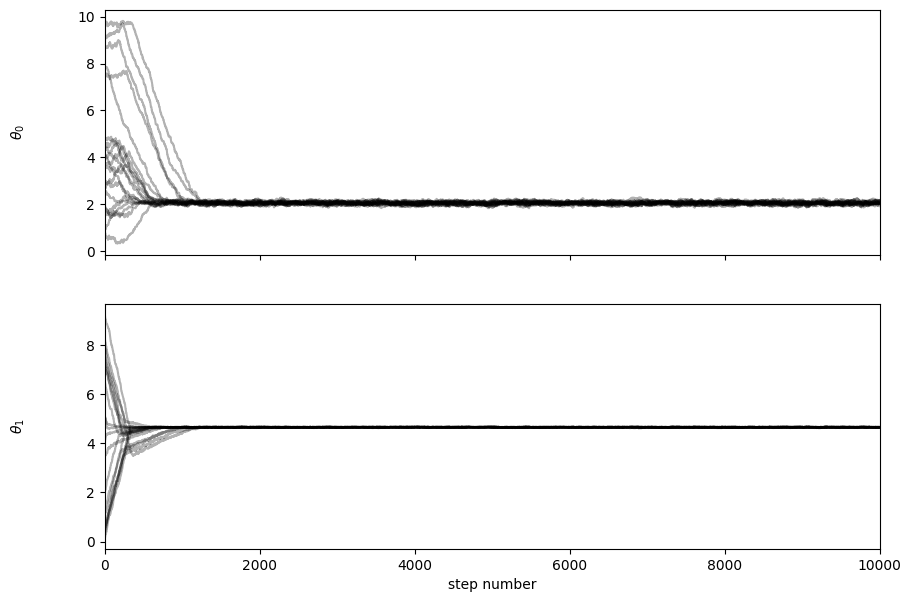

In [12]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)

labels = [r'$\theta_0$',r'$\theta_1$']
for i in range(2):
    ax = axes[i]
    ax.plot(theta_arr[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(theta_arr))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")



Text(0.5, 0, 'step number')

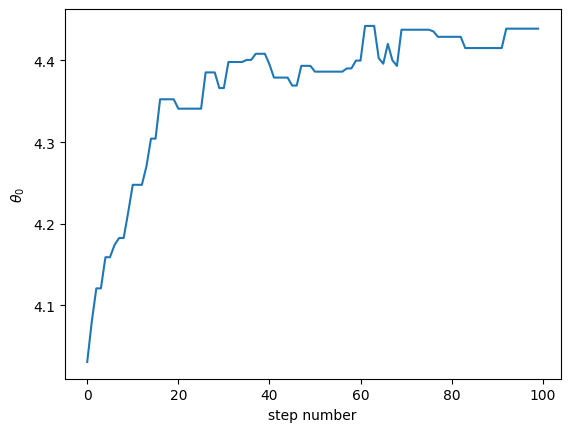

In [13]:
plt.plot(theta_arr[:,0, i][:100])
plt.ylabel(labels[0])
plt.xlabel("step number")

In [14]:
mycode.burn_in(2000)

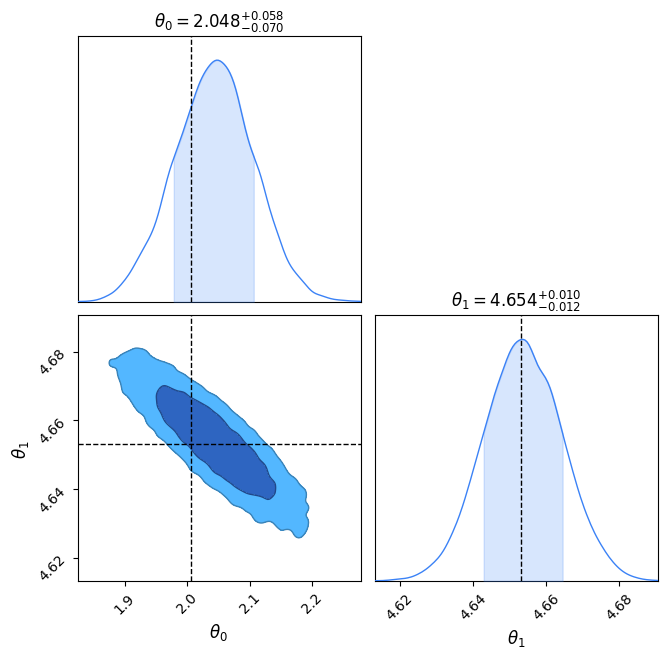

In [15]:
from chainconsumer import Chain, ChainConsumer,Truth
import pandas as pd

chain=mycode.get_chain()

chain = pd.DataFrame(chain, columns=[r'$\theta_0$',r'$\theta_1$'])

c = ChainConsumer()

c.add_chain(Chain(samples=chain, name="An Example Contour"))
c.add_truth(Truth(location={r'$\theta_0$': ture_theta[0], r'$\theta_1$': ture_theta[1]},name='True'))
fig = c.plotter.plot()


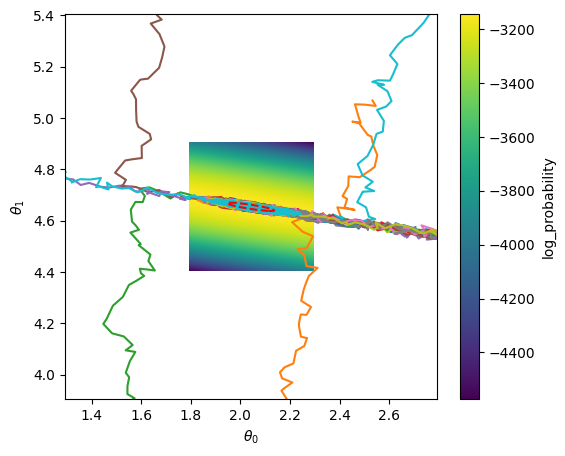

In [16]:

log_p_max = np.max(log_p_arr)

levels = [log_p_max + delta_1sigma]

plt.figure(figsize=(6, 5))
im = plt.imshow(log_p_arr, origin='lower', extent=[theta0.min(), theta0.max(), theta1.min(), theta1.max()],
                cmap='viridis', aspect='auto')


plt.plot(theta_arr[:,:,0],theta_arr[:,:,1])


cs = plt.contour(Theta0, Theta1, log_p_arr, levels=levels, colors='red')
#plt.clabel(cs, fmt={levels[0]: r'$1\sigma$'})

plt.xlim([theta0.min()-0.5, theta0.max()+0.5])
plt.ylim([theta1.min()-0.5, theta1.max()+0.5])
plt.colorbar(im, label='log_probability')
plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')

plt.show()
